In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
import json
import os
import torchvision
import torchvision.transforms as transforms
from math import ceil
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchinfo import summary

## Dataset and Dataloader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
epochs = 100
lr = 0.001
split_size = 0.9

path_to_anns = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\annotations\\all_data.json"
path_to_img = "D:\\Studies\\ucenje\\keypoint_flickr\\data\\images"

In [3]:
class FlickrDatasetRegression(Dataset):
    def __init__(self, path_to_anns, path_to_imgs, transform=None):
        with open(path_to_anns, 'r') as f:
            self.anns = json.loads(f.read())
        self.image_path = path_to_imgs
        self.transform = transform

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_path, self.anns[str(idx)]["file_name"])
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size
        image.thumbnail((224, 224))
        image = np.array(image, dtype=np.uint8)
        keypoints = np.array(self.anns[str(idx)]["face_landmarks"])
        keypoints = keypoints.clip(min=0)
        keypoints = keypoints * [224 / orig_width, 224 / orig_height]
        keypoints = keypoints.flatten()

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(keypoints), idx

dataset = FlickrDatasetRegression(path_to_anns,path_to_img,
                        transform=transforms.ToTensor())
train_len = ceil(len(dataset) * split_size)
val_len = ceil(len(dataset) * (1-split_size))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, (train_len, val_len))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
few_images = [dataset[index] for index in [1,2,3]]
few_images_loader = DataLoader(few_images)
single_image = [dataset[0]]
single_image_loader = DataLoader(single_image)

In [4]:
def get_top_images_dataloader(losses, dataset):
    sorted_loss = sorted(losses, key = lambda x: x[1])
    dataset_to_plot = sorted_loss[:10] + sorted_loss[-10:]
    indexes_to_plot = [x[0].item() for x in dataset_to_plot]
    new_data = [dataset[index] for index in indexes_to_plot]
    dataloader_for_plots = DataLoader(new_data, batch_size=1, shuffle=False)
    return dataloader_for_plots

In [5]:
def plot_img(predictions): # predictions list of tuple (index, predicted_keypoints)
    transform = transforms.ToPILImage() # transform tensor back to PILImage

    images, original_keypoints_list, predicted_keypoints_list = [], [], []

    for i, data in enumerate(predictions):
        image = dataset[data[0].item()][0]
        image = transform(image.cpu().detach())  # Images to PIL, keypoints to numpy array
        images.append(image)
        original_keypoints = dataset[data[0].item()][1]
        original_keypoints = original_keypoints.cpu().detach().numpy().reshape(-1, 2)
        original_keypoints_list.append(original_keypoints)
        predicted_keypoints = data[1].cpu().detach().numpy().reshape(-1, 2)
        predicted_keypoints_list.append(predicted_keypoints)
        for j in range(len(original_keypoints)):
            print(f"Original keypoints x and y: {original_keypoints[j][0]} {original_keypoints[j][1]}")
            print(f"Predicted keypoints x and y: {predicted_keypoints[j][0]} {predicted_keypoints[j][1]}")

    original_keypoints_list = np.array(original_keypoints_list)
    predicted_keypoints_list = np.array(predicted_keypoints_list)


    plt.figure(figsize=(15,50))

    for i in range(len(images) * 2):
        plt.subplot(20, 2, i + 1)
        plt.imshow(images[i // 2])
        if i % 2 == 0:
            for p in range(original_keypoints_list[i//2].shape[0]):
                plt.plot(original_keypoints_list[i//2][p, 0], original_keypoints_list[i//2][p, 1], 'g.')
        else:
            for p in range(predicted_keypoints_list[i//2].shape[0]):
                plt.plot(predicted_keypoints_list[i//2][p, 0], predicted_keypoints_list[i//2][p, 1], 'g.')
    plt.plot()

## Create Model

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(3)
        self.norm = nn.BatchNorm2d(32)
        self.linear1 = nn.Linear(32 * 74 * 74, 256) # 111
        self.linear2 = nn.Linear(256, 136)
    def forward(self, x):
        x = self.norm(self.pool(F.relu(self.conv(x))))
        x = x.view(-1, 32 * 74 * 74)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x


class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.pool = nn.MaxPool2d(2,2)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 2)
        self.conv3 = nn.Conv2d(64, 128, 2)
        self.norm1 = nn.BatchNorm2d(32)
        self.norm2 = nn.BatchNorm2d(64)
        self.linear1 = nn.LazyLinear(1000)
        self.linear2 = nn.Linear(1000, 256)
        self.linear3 = nn.Linear(256, 136)

    def forward(self, x):
        x = self.norm1(self.pool(F.relu(self.conv1(x))))
        x = self.norm2(self.pool(F.relu(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 68, 5)
        self.batch1 = nn.BatchNorm2d(16)
        self.batch2 = nn.BatchNorm2d(32)
        self.batch3 = nn.BatchNorm2d(68)
        self.pool = nn.MaxPool2d(2,2)
        #self.conv_trans1 = nn.ConvTranspose2d(64, 32, 30)  # 30
        #self.conv_trans2 = nn.ConvTranspose2d(32, 16, 58)  # 58
        #self.conv_trans3 = nn.ConvTranspose2d(16, 68, 114)  # 114
        self.upsample1 = nn.Upsample(size=(50, 50), mode="bicubic")
        self.upsample2 = nn.Upsample(size=(110, 110), mode="bicubic")
        self.upsample3 = nn.Upsample(size=(224, 224), mode="bicubic")
    def forward(self, x):
        x = self.batch1(self.pool(F.relu(self.conv1(x))))
        x = self.batch2(self.pool(F.relu(self.conv2(x))))
        x = self.batch3(self.pool(F.relu(self.conv3(x))))
        #x = F.relu(self.conv_trans1(x))
        #x = F.relu(self.conv_trans2(x))
        #x = self.conv_trans3(x)
        x = self.upsample1(x)
        x = self.upsample2(x)
        x = self.upsample3(x)
        return x

In [7]:
model = SimpleCNN().to(device)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 136]                  --
├─Conv2d: 1-1                            [1, 32, 222, 222]         896
├─MaxPool2d: 1-2                         [1, 32, 74, 74]           --
├─BatchNorm2d: 1-3                       [1, 32, 74, 74]           64
├─Linear: 1-4                            [1, 256]                  44,859,648
├─Linear: 1-5                            [1, 136]                  34,952
Total params: 44,895,560
Trainable params: 44,895,560
Non-trainable params: 0
Total mult-adds (M): 89.05
Input size (MB): 0.60
Forward/backward pass size (MB): 14.02
Params size (MB): 179.58
Estimated Total Size (MB): 194.21

# Training with few examples

In [8]:
torch.cuda.empty_cache()
model = SimpleCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
for epoch in range(epochs):
    for i, data in enumerate(few_images_loader):
        image, keypoints = data[0].to(device, torch.float32), data[1].to(device, torch.float32)
        pred = model(image)
        loss = criterion(pred, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())

Original keypoints x and y: 55.59124087591241 102.05352798053528
Predicted keypoints x and y: 58.084983825683594 107.6727066040039
Original keypoints x and y: 55.04622871046229 118.13138686131387
Predicted keypoints x and y: 58.25065994262695 126.5924072265625
Original keypoints x and y: 55.04622871046229 133.9367396593674
Predicted keypoints x and y: 58.692073822021484 143.67074584960938
Original keypoints x and y: 55.86374695863747 149.74209245742094
Predicted keypoints x and y: 59.19523620605469 159.0358428955078
Original keypoints x and y: 59.67883211678832 165.0024330900243
Predicted keypoints x and y: 61.900108337402344 175.3105010986328
Original keypoints x and y: 66.49148418491485 179.71776155717762
Predicted keypoints x and y: 71.50827026367188 191.6585693359375
Original keypoints x and y: 75.21167883211679 193.0705596107056
Predicted keypoints x and y: 77.72660064697266 203.01998901367188
Original keypoints x and y: 86.11192214111921 205.33333333333331
Predicted keypoints x a

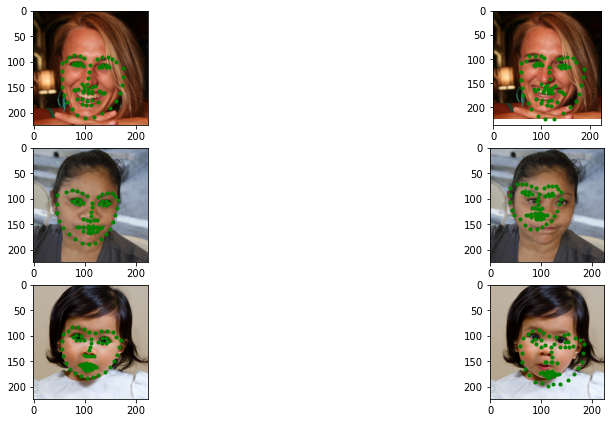

In [9]:
model.eval()
predictions = []
with torch.no_grad():
    for i, data in enumerate(few_images_loader):
        images, keypoints, index = data[0].to(device), data[1].to(device), data[2]
        pred = model(images)
        predictions.append((index, pred))
plot_img(predictions)

In [10]:
train_loss[-10:]

[0.673260509967804,
 0.042508479207754135,
 0.5861557126045227,
 0.6513419151306152,
 0.0366644486784935,
 0.5709889531135559,
 0.6319181323051453,
 0.03165286406874657,
 0.5559211373329163,
 0.6135872006416321]

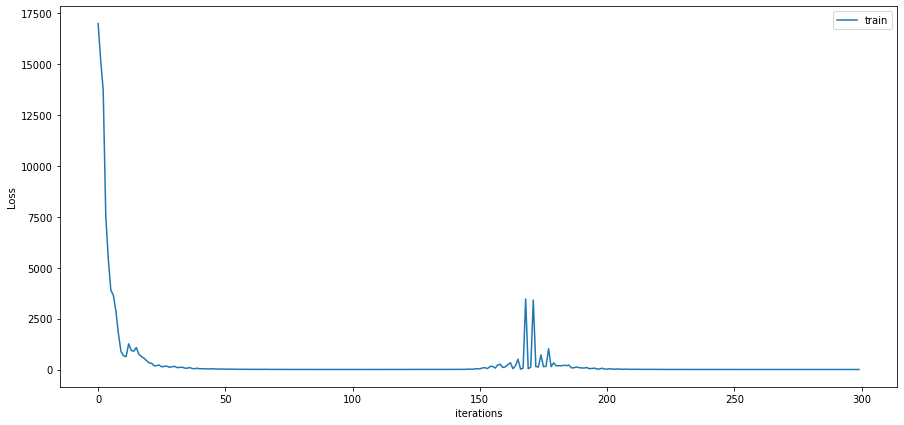

In [11]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Training with a single example

In [12]:
torch.cuda.empty_cache()
model = SimpleCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
for epoch in range(epochs):
    for i, data in enumerate(single_image_loader):
        image, keypoints = data[0].to(device, torch.float32), data[1].to(device,torch.float32)
        pred = model(image)
        loss = criterion(pred, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.item())
        print(f"Epoch number: {epoch + 1}")


Epoch number: 1
Epoch number: 2
Epoch number: 3
Epoch number: 4
Epoch number: 5
Epoch number: 6
Epoch number: 7
Epoch number: 8
Epoch number: 9
Epoch number: 10
Epoch number: 11
Epoch number: 12
Epoch number: 13
Epoch number: 14
Epoch number: 15
Epoch number: 16
Epoch number: 17
Epoch number: 18
Epoch number: 19
Epoch number: 20
Epoch number: 21
Epoch number: 22
Epoch number: 23
Epoch number: 24
Epoch number: 25
Epoch number: 26
Epoch number: 27
Epoch number: 28
Epoch number: 29
Epoch number: 30
Epoch number: 31
Epoch number: 32
Epoch number: 33
Epoch number: 34
Epoch number: 35
Epoch number: 36
Epoch number: 37
Epoch number: 38
Epoch number: 39
Epoch number: 40
Epoch number: 41
Epoch number: 42
Epoch number: 43
Epoch number: 44
Epoch number: 45
Epoch number: 46
Epoch number: 47
Epoch number: 48
Epoch number: 49
Epoch number: 50
Epoch number: 51
Epoch number: 52
Epoch number: 53
Epoch number: 54
Epoch number: 55
Epoch number: 56
Epoch number: 57
Epoch number: 58
Epoch number: 59
Epoch 

In [13]:
train_loss[-10:]

[0.13931500911712646,
 0.12628258764743805,
 0.1197771206498146,
 0.11119616031646729,
 0.09358605742454529,
 0.07705201953649521,
 0.0686006024479866,
 0.06420699506998062,
 0.061053529381752014,
 0.05820105969905853]

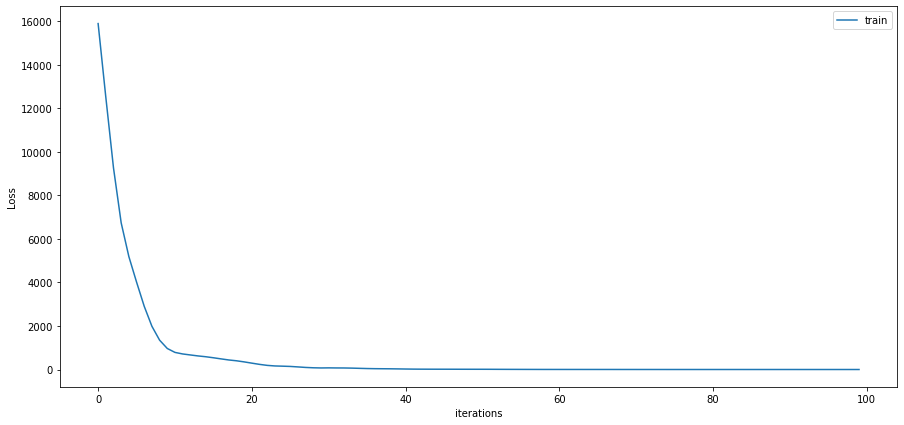

In [14]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Original keypoints x and y: 55.59124087591241 102.05352798053528
Predicted keypoints x and y: 32.62325668334961 104.04603576660156
Original keypoints x and y: 55.04622871046229 118.13138686131387
Predicted keypoints x and y: 35.40018081665039 120.97073364257812
Original keypoints x and y: 55.04622871046229 133.9367396593674
Predicted keypoints x and y: 38.809654235839844 136.78749084472656
Original keypoints x and y: 55.86374695863747 149.74209245742094
Predicted keypoints x and y: 44.69120788574219 152.00624084472656
Original keypoints x and y: 59.67883211678832 165.0024330900243
Predicted keypoints x and y: 55.78879165649414 164.2100830078125
Original keypoints x and y: 66.49148418491485 179.71776155717762
Predicted keypoints x and y: 70.69933319091797 172.27731323242188
Original keypoints x and y: 75.21167883211679 193.0705596107056
Predicted keypoints x and y: 86.90239715576172 177.20106506347656
Original keypoints x and y: 86.11192214111921 205.33333333333331
Predicted keypoints x

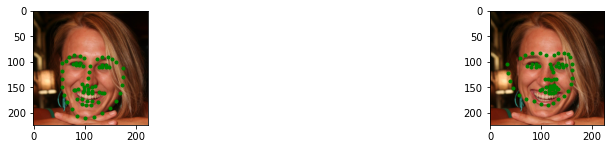

In [15]:
image, _, _= next(iter(single_image_loader))
image = image.to(device)
pred = model(image)
plot_img([(torch.tensor(1), pred)])

 # Train loop for simple CNN

In [16]:
torch.cuda.empty_cache()
model = SimpleCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []

for epoch in range(epochs):
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=(len(train_loader))):
        images, keypoints = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
        preds = model(images)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

    #model.eval()

    #with torch.no_grad():
    #    val_running_loss = 0.0
    #    for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
    #        image, keypoints = data[0].to(device), data[1].to(device)
    #        preds = model(image)
    #        loss = criterion(preds, keypoints)
    #        val_running_loss += loss.item()
    #    val_loss.append(val_running_loss / ceil(len(val_dataset) / batch_size))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')


100%|██████████| 141/141 [00:44<00:00,  3.20it/s]


Epoch: 1
Train_loss at epoch 1: 1126.8988499742873


100%|██████████| 141/141 [00:44<00:00,  3.17it/s]


Epoch: 2
Train_loss at epoch 2: 121.45354028796473


100%|██████████| 141/141 [00:43<00:00,  3.24it/s]


Epoch: 3
Train_loss at epoch 3: 57.55270763153725


100%|██████████| 141/141 [00:43<00:00,  3.22it/s]


Epoch: 4
Train_loss at epoch 4: 34.92172757953617


100%|██████████| 141/141 [00:43<00:00,  3.24it/s]


Epoch: 5
Train_loss at epoch 5: 24.804973243821596


100%|██████████| 141/141 [00:44<00:00,  3.20it/s]


Epoch: 6
Train_loss at epoch 6: 19.599086423292228


100%|██████████| 141/141 [00:43<00:00,  3.22it/s]


Epoch: 7
Train_loss at epoch 7: 17.161745064647484


100%|██████████| 141/141 [00:43<00:00,  3.22it/s]


Epoch: 8
Train_loss at epoch 8: 14.240615459198647


100%|██████████| 141/141 [00:42<00:00,  3.29it/s]


Epoch: 9
Train_loss at epoch 9: 14.743263555756698


100%|██████████| 141/141 [00:43<00:00,  3.25it/s]


Epoch: 10
Train_loss at epoch 10: 14.062107400691255


100%|██████████| 141/141 [00:44<00:00,  3.20it/s]


Epoch: 11
Train_loss at epoch 11: 13.365540754710528


100%|██████████| 141/141 [00:43<00:00,  3.26it/s]


Epoch: 12
Train_loss at epoch 12: 12.399759654457688


100%|██████████| 141/141 [00:43<00:00,  3.22it/s]


Epoch: 13
Train_loss at epoch 13: 10.320510319784178


100%|██████████| 141/141 [00:42<00:00,  3.29it/s]


Epoch: 14
Train_loss at epoch 14: 9.57324594470626


100%|██████████| 141/141 [00:43<00:00,  3.25it/s]


Epoch: 15
Train_loss at epoch 15: 9.48091326368616


100%|██████████| 141/141 [00:42<00:00,  3.30it/s]


Epoch: 16
Train_loss at epoch 16: 9.515666007995605


100%|██████████| 141/141 [00:43<00:00,  3.23it/s]


Epoch: 17
Train_loss at epoch 17: 10.008470491314611


100%|██████████| 141/141 [00:43<00:00,  3.26it/s]


Epoch: 18
Train_loss at epoch 18: 11.0186787598522


100%|██████████| 141/141 [00:43<00:00,  3.25it/s]


Epoch: 19
Train_loss at epoch 19: 13.01750142523583


100%|██████████| 141/141 [00:43<00:00,  3.27it/s]


Epoch: 20
Train_loss at epoch 20: 10.935432126336064


100%|██████████| 141/141 [00:44<00:00,  3.15it/s]


Epoch: 21
Train_loss at epoch 21: 12.631848653157553


100%|██████████| 141/141 [00:43<00:00,  3.26it/s]


Epoch: 22
Train_loss at epoch 22: 10.458013551455018


100%|██████████| 141/141 [00:42<00:00,  3.34it/s]


Epoch: 23
Train_loss at epoch 23: 9.315367698669434


100%|██████████| 141/141 [00:42<00:00,  3.35it/s]


Epoch: 24
Train_loss at epoch 24: 12.38909780894611


100%|██████████| 141/141 [00:41<00:00,  3.38it/s]


Epoch: 25
Train_loss at epoch 25: 11.10193430109227


100%|██████████| 141/141 [00:42<00:00,  3.28it/s]


Epoch: 26
Train_loss at epoch 26: 9.33841005622918


100%|██████████| 141/141 [00:43<00:00,  3.25it/s]


Epoch: 27
Train_loss at epoch 27: 10.26384236288409


100%|██████████| 141/141 [00:42<00:00,  3.33it/s]


Epoch: 28
Train_loss at epoch 28: 6.675850658552021


100%|██████████| 141/141 [00:42<00:00,  3.28it/s]


Epoch: 29
Train_loss at epoch 29: 5.315818913439487


100%|██████████| 141/141 [00:42<00:00,  3.29it/s]


Epoch: 30
Train_loss at epoch 30: 4.461280460898758


100%|██████████| 141/141 [00:42<00:00,  3.28it/s]


Epoch: 31
Train_loss at epoch 31: 4.372714705501043


100%|██████████| 141/141 [00:42<00:00,  3.29it/s]


Epoch: 32
Train_loss at epoch 32: 4.887103089204071


100%|██████████| 141/141 [00:43<00:00,  3.28it/s]


Epoch: 33
Train_loss at epoch 33: 5.6844282539178295


100%|██████████| 141/141 [00:44<00:00,  3.20it/s]


Epoch: 34
Train_loss at epoch 34: 6.072427458796941


100%|██████████| 141/141 [00:44<00:00,  3.20it/s]


Epoch: 35
Train_loss at epoch 35: 6.304465948267186


100%|██████████| 141/141 [00:43<00:00,  3.24it/s]


Epoch: 36
Train_loss at epoch 36: 6.933182550660262


100%|██████████| 141/141 [00:43<00:00,  3.23it/s]


Epoch: 37
Train_loss at epoch 37: 8.318502781238962


100%|██████████| 141/141 [00:43<00:00,  3.21it/s]


Epoch: 38
Train_loss at epoch 38: 6.236537889385899


100%|██████████| 141/141 [00:43<00:00,  3.23it/s]


Epoch: 39
Train_loss at epoch 39: 5.926711376677168


100%|██████████| 141/141 [00:43<00:00,  3.22it/s]


Epoch: 40
Train_loss at epoch 40: 4.367566609213538


100%|██████████| 141/141 [00:43<00:00,  3.23it/s]


Epoch: 41
Train_loss at epoch 41: 3.3926586682069386


100%|██████████| 141/141 [00:43<00:00,  3.23it/s]


Epoch: 42
Train_loss at epoch 42: 3.4638482864866864


100%|██████████| 141/141 [00:43<00:00,  3.24it/s]


Epoch: 43
Train_loss at epoch 43: 3.832471270933219


100%|██████████| 141/141 [00:43<00:00,  3.22it/s]


Epoch: 44
Train_loss at epoch 44: 4.108905744890794


100%|██████████| 141/141 [00:43<00:00,  3.25it/s]


Epoch: 45
Train_loss at epoch 45: 3.865075652480971


100%|██████████| 141/141 [00:44<00:00,  3.19it/s]


Epoch: 46
Train_loss at epoch 46: 4.0194431619441255


100%|██████████| 141/141 [00:43<00:00,  3.24it/s]


Epoch: 47
Train_loss at epoch 47: 4.320145008411814


100%|██████████| 141/141 [00:43<00:00,  3.25it/s]


Epoch: 48
Train_loss at epoch 48: 4.354489010276524


100%|██████████| 141/141 [00:40<00:00,  3.46it/s]


Epoch: 49
Train_loss at epoch 49: 3.9572618912297783


100%|██████████| 141/141 [00:41<00:00,  3.41it/s]


Epoch: 50
Train_loss at epoch 50: 2.7801358716707703


100%|██████████| 141/141 [00:40<00:00,  3.46it/s]


Epoch: 51
Train_loss at epoch 51: 2.930858371951056


100%|██████████| 141/141 [00:43<00:00,  3.22it/s]


Epoch: 52
Train_loss at epoch 52: 2.43998517804112


100%|██████████| 141/141 [00:41<00:00,  3.36it/s]


Epoch: 53
Train_loss at epoch 53: 2.5541145742362272


100%|██████████| 141/141 [00:40<00:00,  3.47it/s]


Epoch: 54
Train_loss at epoch 54: 2.6199480574181737


100%|██████████| 141/141 [00:41<00:00,  3.38it/s]


Epoch: 55
Train_loss at epoch 55: 2.7565178203244582


100%|██████████| 141/141 [00:41<00:00,  3.36it/s]


Epoch: 56
Train_loss at epoch 56: 2.7376614208762526


100%|██████████| 141/141 [00:41<00:00,  3.36it/s]


Epoch: 57
Train_loss at epoch 57: 2.481824444540849


100%|██████████| 141/141 [00:41<00:00,  3.38it/s]


Epoch: 58
Train_loss at epoch 58: 1.9981537744508568


100%|██████████| 141/141 [00:43<00:00,  3.27it/s]


Epoch: 59
Train_loss at epoch 59: 2.2908446374514426


100%|██████████| 141/141 [00:41<00:00,  3.37it/s]


Epoch: 60
Train_loss at epoch 60: 2.243066782646991


100%|██████████| 141/141 [00:42<00:00,  3.36it/s]


Epoch: 61
Train_loss at epoch 61: 2.366815351425333


100%|██████████| 141/141 [00:40<00:00,  3.44it/s]


Epoch: 62
Train_loss at epoch 62: 2.0607885553481733


100%|██████████| 141/141 [00:40<00:00,  3.48it/s]


Epoch: 63
Train_loss at epoch 63: 1.7847969667285892


100%|██████████| 141/141 [00:40<00:00,  3.46it/s]


Epoch: 64
Train_loss at epoch 64: 1.9544824733801767


100%|██████████| 141/141 [00:41<00:00,  3.38it/s]


Epoch: 65
Train_loss at epoch 65: 2.2148571377950357


100%|██████████| 141/141 [00:43<00:00,  3.25it/s]


Epoch: 66
Train_loss at epoch 66: 1.953453062273932


100%|██████████| 141/141 [00:42<00:00,  3.34it/s]


Epoch: 67
Train_loss at epoch 67: 2.070935125046588


100%|██████████| 141/141 [00:41<00:00,  3.42it/s]


Epoch: 68
Train_loss at epoch 68: 1.709677886455617


100%|██████████| 141/141 [00:41<00:00,  3.43it/s]


Epoch: 69
Train_loss at epoch 69: 1.8602276300707608


100%|██████████| 141/141 [00:41<00:00,  3.39it/s]


Epoch: 70
Train_loss at epoch 70: 1.617552547590107


100%|██████████| 141/141 [00:41<00:00,  3.41it/s]


Epoch: 71
Train_loss at epoch 71: 1.4880639969879854


100%|██████████| 141/141 [00:41<00:00,  3.41it/s]


Epoch: 72
Train_loss at epoch 72: 1.3673105248322723


100%|██████████| 141/141 [00:41<00:00,  3.40it/s]


Epoch: 73
Train_loss at epoch 73: 1.4358270671350737


100%|██████████| 141/141 [00:44<00:00,  3.16it/s]


Epoch: 74
Train_loss at epoch 74: 1.4710446164963094


100%|██████████| 141/141 [00:43<00:00,  3.28it/s]


Epoch: 75
Train_loss at epoch 75: 1.8057596970957221


100%|██████████| 141/141 [00:41<00:00,  3.39it/s]


Epoch: 76
Train_loss at epoch 76: 1.6808388977186055


100%|██████████| 141/141 [00:41<00:00,  3.39it/s]


Epoch: 77
Train_loss at epoch 77: 1.3934895193323176


100%|██████████| 141/141 [00:41<00:00,  3.39it/s]


Epoch: 78
Train_loss at epoch 78: 1.3873004439874743


100%|██████████| 141/141 [00:41<00:00,  3.39it/s]


Epoch: 79
Train_loss at epoch 79: 1.2532068930619151


100%|██████████| 141/141 [00:41<00:00,  3.38it/s]


Epoch: 80
Train_loss at epoch 80: 1.1478782503317433


100%|██████████| 141/141 [00:41<00:00,  3.37it/s]


Epoch: 81
Train_loss at epoch 81: 1.1442768958443446


100%|██████████| 141/141 [00:41<00:00,  3.39it/s]


Epoch: 82
Train_loss at epoch 82: 1.1901288396077798


100%|██████████| 141/141 [00:45<00:00,  3.09it/s]


Epoch: 83
Train_loss at epoch 83: 1.1126511663409835


100%|██████████| 141/141 [00:42<00:00,  3.30it/s]


Epoch: 84
Train_loss at epoch 84: 1.336701380445602


100%|██████████| 141/141 [00:42<00:00,  3.35it/s]


Epoch: 85
Train_loss at epoch 85: 1.3232392524996548


100%|██████████| 141/141 [00:42<00:00,  3.34it/s]


Epoch: 86
Train_loss at epoch 86: 1.4474091280436685


100%|██████████| 141/141 [00:42<00:00,  3.35it/s]


Epoch: 87
Train_loss at epoch 87: 1.0871190800734445


100%|██████████| 141/141 [00:42<00:00,  3.34it/s]


Epoch: 88
Train_loss at epoch 88: 0.9092537016733319


100%|██████████| 141/141 [00:42<00:00,  3.28it/s]


Epoch: 89
Train_loss at epoch 89: 0.8906166101178379


100%|██████████| 141/141 [00:43<00:00,  3.28it/s]


Epoch: 90
Train_loss at epoch 90: 1.2912046968514193


100%|██████████| 141/141 [00:43<00:00,  3.27it/s]


Epoch: 91
Train_loss at epoch 91: 1.224968231738882


100%|██████████| 141/141 [00:43<00:00,  3.26it/s]


Epoch: 92
Train_loss at epoch 92: 1.1561859562887367


100%|██████████| 141/141 [00:43<00:00,  3.25it/s]


Epoch: 93
Train_loss at epoch 93: 1.0829036054036296


100%|██████████| 141/141 [00:43<00:00,  3.26it/s]


Epoch: 94
Train_loss at epoch 94: 1.0081521936342226


100%|██████████| 141/141 [00:44<00:00,  3.20it/s]


Epoch: 95
Train_loss at epoch 95: 0.8473459279283564


100%|██████████| 141/141 [00:42<00:00,  3.31it/s]


Epoch: 96
Train_loss at epoch 96: 0.8662283424790024


100%|██████████| 141/141 [00:42<00:00,  3.31it/s]


Epoch: 97
Train_loss at epoch 97: 0.82680237377789


100%|██████████| 141/141 [00:45<00:00,  3.13it/s]


Epoch: 98
Train_loss at epoch 98: 0.8941839409212694


100%|██████████| 141/141 [00:44<00:00,  3.15it/s]


Epoch: 99
Train_loss at epoch 99: 0.9274203582858362


100%|██████████| 141/141 [00:43<00:00,  3.28it/s]

Epoch: 100
Train_loss at epoch 100: 0.8341393508809678


## Plot loss

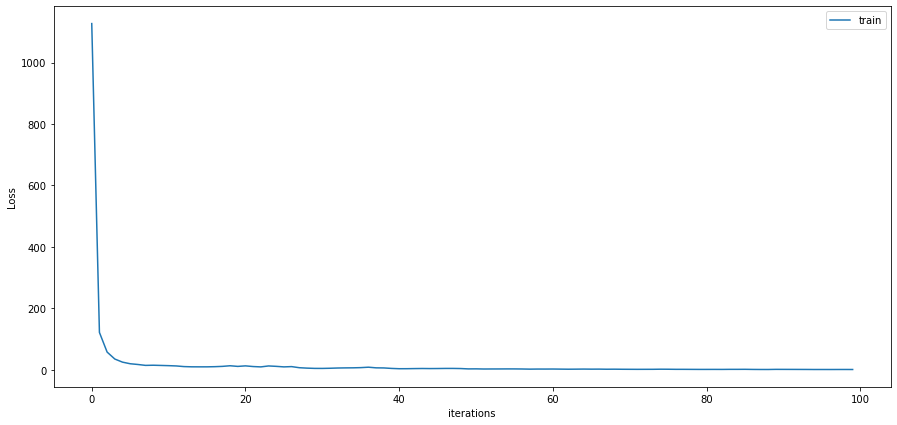

In [17]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Find top 10 best and worst performing images

In [18]:
model.eval()

val_losses = []
with torch.no_grad():
    for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
        image, keypoints, index = data[0].to(device), data[1].to(device), data[2]
        pred = model(image)
        loss = criterion(pred, keypoints)
        val_losses.append((index, loss.item())) # (index, loss)


100%|██████████| 500/500 [00:05<00:00, 99.05it/s] 


In [19]:
dataloader_for_plots = get_top_images_dataloader(val_losses, dataset)

In [20]:
model.eval()
predictions = []
with torch.no_grad():
    for i, data in enumerate(dataloader_for_plots):
        images, keypoints, index = data[0].to(device), data[1].to(device), data[2]
        pred = model(image)
        predictions.append((index, pred))

Original keypoints x and y: 47.876765083440304 111.42490372272144
Predicted keypoints x and y: 63.474571228027344 109.3590087890625
Original keypoints x and y: 50.177150192554556 126.95250320924262
Predicted keypoints x and y: 62.42406463623047 123.53916931152344
Original keypoints x and y: 52.47753530166881 141.90500641848524
Predicted keypoints x and y: 63.59563064575195 137.46006774902344
Original keypoints x and y: 54.777920410783054 157.43260590500643
Predicted keypoints x and y: 66.78289031982422 151.4124298095703
Original keypoints x and y: 59.95378690629011 172.38510911424902
Predicted keypoints x and y: 72.05968475341797 164.98899841308594
Original keypoints x and y: 70.30551989730424 184.46213093709883
Predicted keypoints x and y: 79.87693786621094 177.09884643554688
Original keypoints x and y: 85.25802310654686 193.66367137355584
Predicted keypoints x and y: 90.07508850097656 187.88284301757812
Original keypoints x and y: 101.93581514762516 201.13992297817717
Predicted keypo

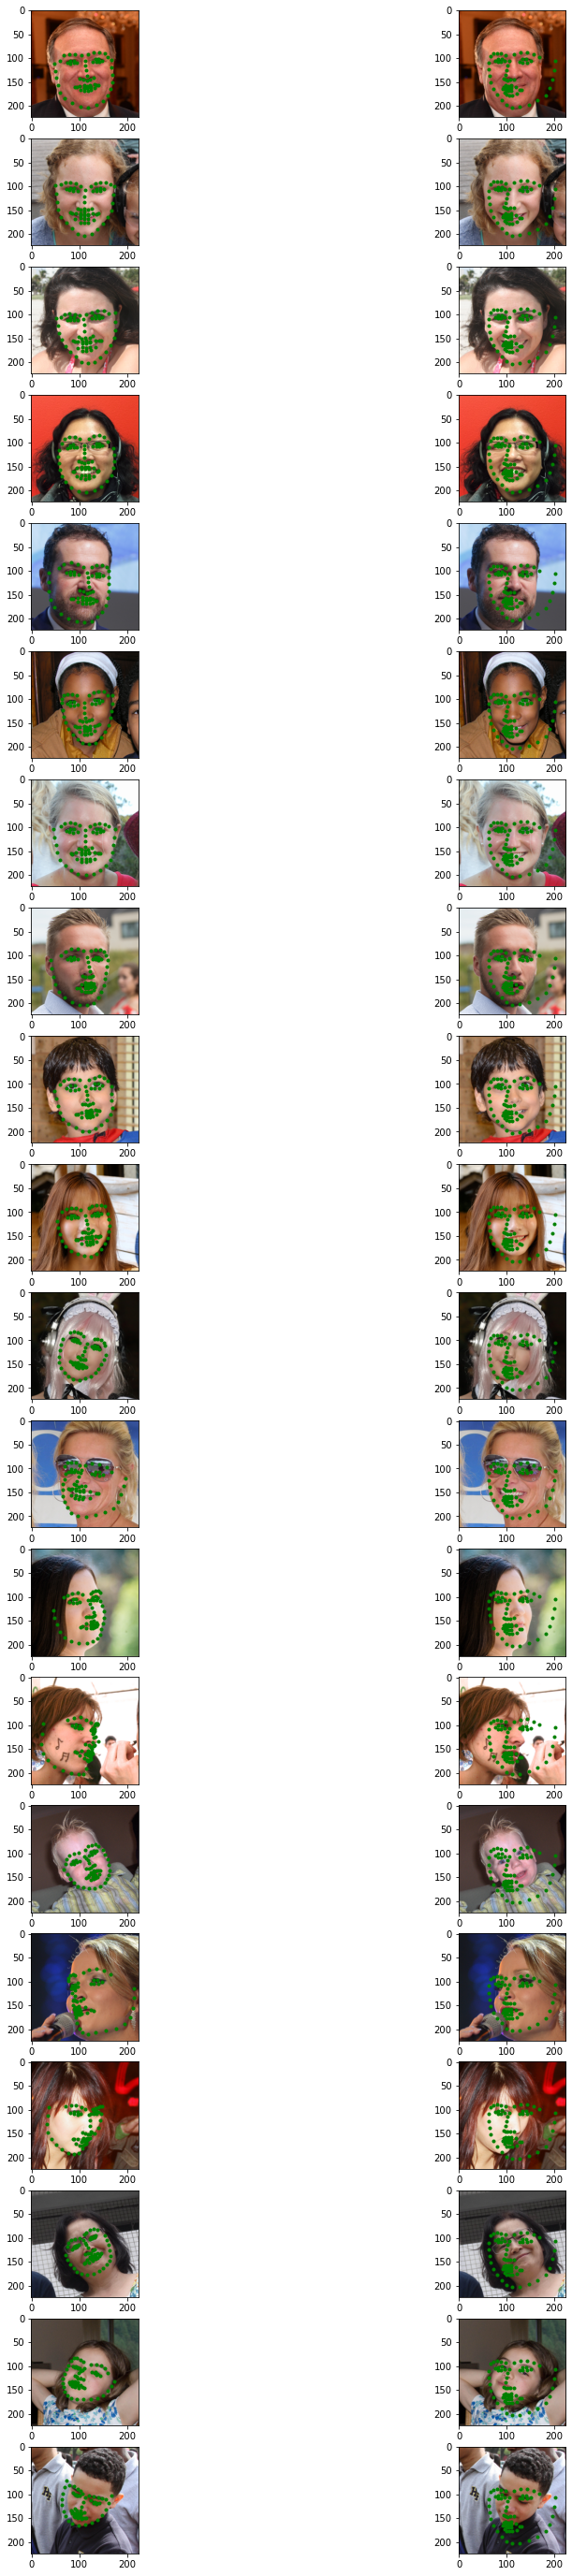

In [21]:
plot_img(predictions)

# Classification part

In [22]:
class FlickrDatasetClassification(Dataset):
    def __init__(self, path_to_anns, path_to_imgs, transform=None):
        with open(path_to_anns, 'r') as f:
            self.anns = json.loads(f.read())
        self.image_path = path_to_imgs
        self.transform = transform

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_path, self.anns[str(idx)]["file_name"])
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size

        image.thumbnail((224, 224))
        image = np.array(image, dtype=np.uint8)
        keypoints = np.array(self.anns[str(idx)]["face_landmarks"], dtype=np.float32)
        keypoints = keypoints.clip(min=0, max=orig_height if orig_height >= orig_width else orig_width)
        keypoints = keypoints * [224.0 / orig_width, 224.0 / orig_height]
        keypoints = keypoints.astype('uint8')
        new_keypoints = torch.zeros(68, 224, 224)
        for i in range(len(new_keypoints)):
            new_keypoints[i][keypoints[i][0]-1][keypoints[i][1]-1] = 1
        if self.transform:
            image = self.transform(image)

        return image, new_keypoints, idx

dataset_classification = FlickrDatasetClassification(path_to_anns,path_to_img,
                        transform=transforms.ToTensor())
train_len = ceil(len(dataset_classification) * split_size)
val_len = ceil(len(dataset_classification) * (1-split_size))
train_dataset_classification, val_dataset_classification = torch.utils.data.random_split(dataset_classification, (train_len, val_len))
train_loader_classification = DataLoader(train_dataset_classification, batch_size=batch_size, shuffle=True)
val_loader_classification = DataLoader(val_dataset_classification, batch_size=1, shuffle=False)

In [23]:
model = ClassificationCNN().to(device)
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ClassificationCNN                        [32, 68, 224, 224]        --
├─Conv2d: 1-1                            [32, 16, 222, 222]        448
├─MaxPool2d: 1-2                         [32, 16, 111, 111]        --
├─BatchNorm2d: 1-3                       [32, 16, 111, 111]        32
├─Conv2d: 1-4                            [32, 32, 109, 109]        4,640
├─MaxPool2d: 1-5                         [32, 32, 54, 54]          --
├─BatchNorm2d: 1-6                       [32, 32, 54, 54]          64
├─Conv2d: 1-7                            [32, 68, 50, 50]          54,468
├─MaxPool2d: 1-8                         [32, 68, 25, 25]          --
├─BatchNorm2d: 1-9                       [32, 68, 25, 25]          136
├─Upsample: 1-10                         [32, 68, 50, 50]          --
├─Upsample: 1-11                         [32, 68, 110, 110]        --
├─Upsample: 1-12                         [32, 68, 224, 224]        --
Total 

In [24]:
torch.cuda.empty_cache()
#model = ClassificationCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []

for epoch in range(epochs):
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader_classification), total=(len(train_loader_classification))):
        images, keypoints = data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)
        preds = model(images)
        loss = criterion(preds, keypoints)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_running_loss += loss.item()
    train_loss.append(train_running_loss / (ceil(len(train_dataset) / batch_size)))

    #model.eval()

    #with torch.no_grad():
    #    val_running_loss = 0.0
    #    for i, data in tqdm(enumerate(val_loader), total=(len(val_loader))):
    #        image, keypoints = data[0].to(device), data[1].to(device)
    #        preds = model(image)
    #        loss = criterion(preds, keypoints)
    #        val_running_loss += loss.item()
    #    val_loss.append(val_running_loss / ceil(len(val_dataset) / batch_size))
    print(f'Epoch: {epoch + 1}')
    print(f'Train_loss at epoch {epoch + 1}: {train_loss[-1]}')


100%|██████████| 141/141 [01:32<00:00,  1.53it/s]


Epoch: 1
Train_loss at epoch 1: 0.0043961546327654566


100%|██████████| 141/141 [01:36<00:00,  1.46it/s]


Epoch: 2
Train_loss at epoch 2: 0.0036385027008091517


100%|██████████| 141/141 [01:40<00:00,  1.41it/s]


Epoch: 3
Train_loss at epoch 3: 0.0034326046725061347


100%|██████████| 141/141 [01:37<00:00,  1.44it/s]


Epoch: 4
Train_loss at epoch 4: 0.0033028911838823174


100%|██████████| 141/141 [01:39<00:00,  1.42it/s]


Epoch: 5
Train_loss at epoch 5: 0.003234499241456601


100%|██████████| 141/141 [01:38<00:00,  1.43it/s]


Epoch: 6
Train_loss at epoch 6: 0.00317381490814559


100%|██████████| 141/141 [01:43<00:00,  1.36it/s]


Epoch: 7
Train_loss at epoch 7: 0.0031315834106256566


100%|██████████| 141/141 [01:40<00:00,  1.40it/s]


Epoch: 8
Train_loss at epoch 8: 0.003095345213309142


100%|██████████| 141/141 [01:42<00:00,  1.38it/s]


Epoch: 9
Train_loss at epoch 9: 0.0030646554412359886


100%|██████████| 141/141 [01:38<00:00,  1.44it/s]


Epoch: 10
Train_loss at epoch 10: 0.003043490045882286


100%|██████████| 141/141 [01:40<00:00,  1.41it/s]


Epoch: 11
Train_loss at epoch 11: 0.0030179076946954776


100%|██████████| 141/141 [01:38<00:00,  1.43it/s]


Epoch: 12
Train_loss at epoch 12: 0.0030011697028307837


100%|██████████| 141/141 [01:37<00:00,  1.45it/s]


Epoch: 13
Train_loss at epoch 13: 0.0029842570879833495


100%|██████████| 141/141 [01:40<00:00,  1.41it/s]


Epoch: 14
Train_loss at epoch 14: 0.002963496464575436


100%|██████████| 141/141 [01:38<00:00,  1.44it/s]


Epoch: 15
Train_loss at epoch 15: 0.002957712862217891


100%|██████████| 141/141 [01:35<00:00,  1.48it/s]


Epoch: 16
Train_loss at epoch 16: 0.0029443941617397764


100%|██████████| 141/141 [01:34<00:00,  1.49it/s]


Epoch: 17
Train_loss at epoch 17: 0.0029321007103599766


100%|██████████| 141/141 [01:37<00:00,  1.45it/s]


Epoch: 18
Train_loss at epoch 18: 0.0029186650281705965


100%|██████████| 141/141 [01:35<00:00,  1.47it/s]


Epoch: 19
Train_loss at epoch 19: 0.0029087573180886657


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 20
Train_loss at epoch 20: 0.002904032342175537


100%|██████████| 141/141 [01:35<00:00,  1.48it/s]


Epoch: 21
Train_loss at epoch 21: 0.002898446619444599


100%|██████████| 141/141 [01:36<00:00,  1.46it/s]


Epoch: 22
Train_loss at epoch 22: 0.0028830753071299683


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 23
Train_loss at epoch 23: 0.0028791842711362856


100%|██████████| 141/141 [01:36<00:00,  1.47it/s]


Epoch: 24
Train_loss at epoch 24: 0.002872366276536639


100%|██████████| 141/141 [01:35<00:00,  1.48it/s]


Epoch: 25
Train_loss at epoch 25: 0.0028645182788002155


100%|██████████| 141/141 [01:38<00:00,  1.44it/s]


Epoch: 26
Train_loss at epoch 26: 0.0028591637767138


100%|██████████| 141/141 [01:31<00:00,  1.53it/s]


Epoch: 27
Train_loss at epoch 27: 0.0028447969717548247


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 28
Train_loss at epoch 28: 0.002838751656194845


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 29
Train_loss at epoch 29: 0.0028411490456300213


100%|██████████| 141/141 [01:29<00:00,  1.58it/s]


Epoch: 30
Train_loss at epoch 30: 0.0028303480634452602


100%|██████████| 141/141 [01:29<00:00,  1.58it/s]


Epoch: 31
Train_loss at epoch 31: 0.002829060772539559


100%|██████████| 141/141 [01:29<00:00,  1.58it/s]


Epoch: 32
Train_loss at epoch 32: 0.0028208970547990595


100%|██████████| 141/141 [01:29<00:00,  1.58it/s]


Epoch: 33
Train_loss at epoch 33: 0.002823194095878102


100%|██████████| 141/141 [01:29<00:00,  1.58it/s]


Epoch: 34
Train_loss at epoch 34: 0.002808556636029207


100%|██████████| 141/141 [01:30<00:00,  1.57it/s]


Epoch: 35
Train_loss at epoch 35: 0.0028072565163201686


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 36
Train_loss at epoch 36: 0.0028035046123232404


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 37
Train_loss at epoch 37: 0.0028027817573900342


100%|██████████| 141/141 [01:29<00:00,  1.58it/s]


Epoch: 38
Train_loss at epoch 38: 0.0027959305869005883


100%|██████████| 141/141 [01:29<00:00,  1.58it/s]


Epoch: 39
Train_loss at epoch 39: 0.002794437699931416


100%|██████████| 141/141 [01:31<00:00,  1.53it/s]


Epoch: 40
Train_loss at epoch 40: 0.002797227445329335


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 41
Train_loss at epoch 41: 0.0027808324625411777


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 42
Train_loss at epoch 42: 0.0027848959715495295


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 43
Train_loss at epoch 43: 0.002782016761389607


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 44
Train_loss at epoch 44: 0.002773157180557754


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 45
Train_loss at epoch 45: 0.0027722740687879054


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 46
Train_loss at epoch 46: 0.0027611352873186694


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 47
Train_loss at epoch 47: 0.0027662619175587563


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 48
Train_loss at epoch 48: 0.0027639495856161657


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 49
Train_loss at epoch 49: 0.0027609113884548135


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 50
Train_loss at epoch 50: 0.0027596156116152276


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 51
Train_loss at epoch 51: 0.002755732102161075


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 52
Train_loss at epoch 52: 0.0027508127770604607


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 53
Train_loss at epoch 53: 0.00274807150006717


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 54
Train_loss at epoch 54: 0.002754344026961014


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 55
Train_loss at epoch 55: 0.002746762364362994


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 56
Train_loss at epoch 56: 0.002739257702656777


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 57
Train_loss at epoch 57: 0.002742207843598956


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 58
Train_loss at epoch 58: 0.002735705415434237


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 59
Train_loss at epoch 59: 0.002736306115192302


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 60
Train_loss at epoch 60: 0.0027340072147706723


100%|██████████| 141/141 [01:30<00:00,  1.55it/s]


Epoch: 61
Train_loss at epoch 61: 0.0027299708726399754


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 62
Train_loss at epoch 62: 0.0027273338724006996


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 63
Train_loss at epoch 63: 0.0027316604816876615


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 64
Train_loss at epoch 64: 0.0027261756291177045


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 65
Train_loss at epoch 65: 0.002724796589728154


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 66
Train_loss at epoch 66: 0.002725984080503067


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 67
Train_loss at epoch 67: 0.0027191758515802047


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 68
Train_loss at epoch 68: 0.002717992910084889


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 69
Train_loss at epoch 69: 0.0027137644744167724


100%|██████████| 141/141 [01:31<00:00,  1.53it/s]


Epoch: 70
Train_loss at epoch 70: 0.00271560223145635


100%|██████████| 141/141 [01:32<00:00,  1.53it/s]


Epoch: 71
Train_loss at epoch 71: 0.0027096035943122198


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 72
Train_loss at epoch 72: 0.0027091270048461907


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 73
Train_loss at epoch 73: 0.0027084025118420734


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 74
Train_loss at epoch 74: 0.0027099418757707936


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 75
Train_loss at epoch 75: 0.0027051197797562003


100%|██████████| 141/141 [01:32<00:00,  1.53it/s]


Epoch: 76
Train_loss at epoch 76: 0.002699493187816536


100%|██████████| 141/141 [01:39<00:00,  1.42it/s]


Epoch: 77
Train_loss at epoch 77: 0.002702096198084401


100%|██████████| 141/141 [01:34<00:00,  1.49it/s]


Epoch: 78
Train_loss at epoch 78: 0.0027039466650350718


100%|██████████| 141/141 [01:33<00:00,  1.51it/s]


Epoch: 79
Train_loss at epoch 79: 0.0026992143458746216


100%|██████████| 141/141 [01:32<00:00,  1.53it/s]


Epoch: 80
Train_loss at epoch 80: 0.0027013674596364193


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 81
Train_loss at epoch 81: 0.002695362972003137


100%|██████████| 141/141 [01:31<00:00,  1.54it/s]


Epoch: 82
Train_loss at epoch 82: 0.0026905033704395414


100%|██████████| 141/141 [01:32<00:00,  1.53it/s]


Epoch: 83
Train_loss at epoch 83: 0.0026936118543834974


100%|██████████| 141/141 [01:32<00:00,  1.52it/s]


Epoch: 84
Train_loss at epoch 84: 0.002691938880342224


100%|██████████| 141/141 [01:35<00:00,  1.48it/s]


Epoch: 85
Train_loss at epoch 85: 0.002686374439322885


100%|██████████| 141/141 [01:34<00:00,  1.49it/s]


Epoch: 86
Train_loss at epoch 86: 0.002690852687410112


100%|██████████| 141/141 [01:36<00:00,  1.47it/s]


Epoch: 87
Train_loss at epoch 87: 0.002690828585310291


100%|██████████| 141/141 [01:31<00:00,  1.55it/s]


Epoch: 88
Train_loss at epoch 88: 0.002687528661736254


100%|██████████| 141/141 [01:35<00:00,  1.48it/s]


Epoch: 89
Train_loss at epoch 89: 0.0026904273371984983


100%|██████████| 141/141 [01:37<00:00,  1.44it/s]


Epoch: 90
Train_loss at epoch 90: 0.0026844931743272866


100%|██████████| 141/141 [01:37<00:00,  1.45it/s]


Epoch: 91
Train_loss at epoch 91: 0.002685056297531259


100%|██████████| 141/141 [01:35<00:00,  1.48it/s]


Epoch: 92
Train_loss at epoch 92: 0.002681519593449032


100%|██████████| 141/141 [01:36<00:00,  1.45it/s]


Epoch: 93
Train_loss at epoch 93: 0.002679662382666101


100%|██████████| 141/141 [01:34<00:00,  1.50it/s]


Epoch: 94
Train_loss at epoch 94: 0.0026791025157885773


100%|██████████| 141/141 [01:36<00:00,  1.46it/s]


Epoch: 95
Train_loss at epoch 95: 0.0026773565253969413


100%|██████████| 141/141 [01:35<00:00,  1.47it/s]


Epoch: 96
Train_loss at epoch 96: 0.0026806493616722367


100%|██████████| 141/141 [01:36<00:00,  1.47it/s]


Epoch: 97
Train_loss at epoch 97: 0.0026743135345663797


100%|██████████| 141/141 [01:35<00:00,  1.48it/s]


Epoch: 98
Train_loss at epoch 98: 0.0026785018061228254


100%|██████████| 141/141 [01:37<00:00,  1.44it/s]


Epoch: 99
Train_loss at epoch 99: 0.0026730665695979027


100%|██████████| 141/141 [01:36<00:00,  1.46it/s]

Epoch: 100
Train_loss at epoch 100: 0.0026689848502609113


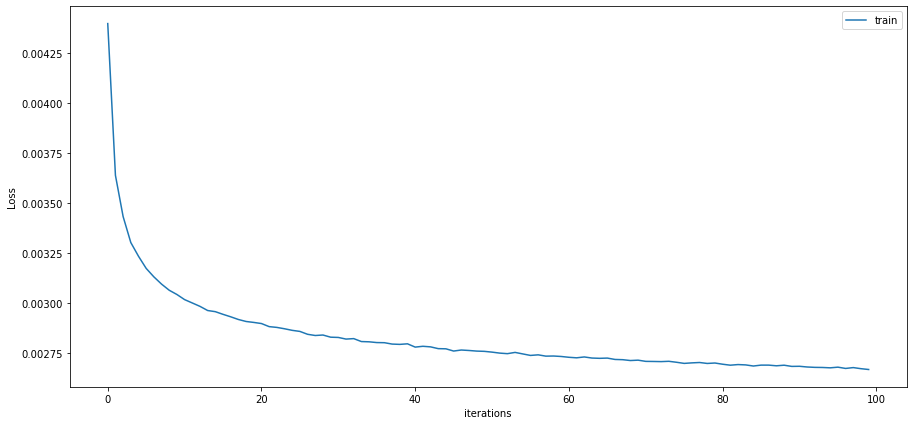

In [25]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Eden primerok, dali kje overfittne mrezhata, -> 0 lossot
So dve sliki, vidi ja razlikata vo lossot megju tie dve sliki
Smeni lazyLinear -> najgolema promena
Interpolacija(subsampling) mesto conv2d, probaj i so conv2d, ama mn pomalce filtri, pregolem model inache.

# Validation test

In [38]:
model.eval()
predictions = []
soft = nn.Softmax(dim=1)
with torch.no_grad():
    for i, data in enumerate(val_loader_classification):
        images, keypoints, index = data[0].to(device), data[1].to(device), data[2]
        pred = model(images)
        pred = soft(pred)
        predictions.append((index, pred))

In [39]:
def plot_img_classification(predictions): # predictions list of tuple (index, predicted_keypoints)
    transform = transforms.ToPILImage() # transform tensor back to PILImage

    images, original_keypoints_list, predicted_keypoints_list = [], [], []

    for i, data in enumerate(predictions):
        image = dataset[data[0].item()][0]
        image = transform(image.cpu().detach())  # Images to PIL, keypoints to numpy array
        images.append(image)
        original_keypoints = dataset[data[0].item()][1]
        original_keypoints = original_keypoints.cpu().detach().numpy().reshape(-1, 2)
        original_keypoints_list.append(original_keypoints)
        predicted_keypoints = data[1].cpu().detach()
        predicted_keypoints_numpy = np.zeros((68, 2), dtype="int32")
        for i in range(68): # per channel
            index = predicted_keypoints[0][i].argmax().item()
            predicted_keypoints_numpy[i] = index // 224, index % 224
        predicted_keypoints_list.append(predicted_keypoints_numpy)


    original_keypoints_list = np.array(original_keypoints_list)
    predicted_keypoints_list = np.array(predicted_keypoints_list)

    plt.figure(figsize=(40,80))
    for i in range(40):
        plt.subplot(20, 2, i + 1)
        plt.imshow(images[i // 2])
        if i % 2 == 0:
            for p in range(original_keypoints_list[i//2].shape[0]):
                plt.plot(original_keypoints_list[i//2][p, 0], original_keypoints_list[i//2][p, 1], 'g.')
        else:
            for p in range(predicted_keypoints_list[i//2].shape[0]):
                plt.plot(predicted_keypoints_list[i//2][p, 0], predicted_keypoints_list[i//2][p, 1], 'g.')
    print(predicted_keypoints_list[0])
    print(print(predictions[0][1]))
    plt.plot()

[[ 33  93]
 [ 93  75]
 [ 40 143]
 [ 44 154]
 [ 44 164]
 [ 14 156]
 [ 65 168]
 [208 168]
 [ 88  12]
 [146  25]
 [102 178]
 [183 148]
 [223 133]
 [223 147]
 [149 132]
 [175 136]
 [175  98]
 [ 13  61]
 [103  64]
 [129 113]
 [ 93  88]
 [101  90]
 [120  87]
 [130  85]
 [143  87]
 [149  88]
 [156 102]
 [110 117]
 [109 126]
 [116 130]
 [111 135]
 [ 97 138]
 [105  79]
 [109 142]
 [105 148]
 [122 140]
 [192 118]
 [ 91  97]
 [ 89 102]
 [ 98 103]
 [ 95 129]
 [206 111]
 [120 107]
 [124 104]
 [146 104]
 [166  88]
 [140 106]
 [134 116]
 [ 76 150]
 [ 94 151]
 [103 153]
 [110 151]
 [116 152]
 [123 151]
 [177  67]
 [137 172]
 [111 168]
 [ 93 171]
 [ 93 167]
 [ 93 162]
 [ 90 158]
 [101 159]
 [111  98]
 [117 154]
 [148 138]
 [110 163]
 [207 156]
 [ 98 162]]
tensor([[[[0.0042, 0.0042, 0.0043,  ..., 0.0035, 0.0036, 0.0036],
          [0.0043, 0.0043, 0.0043,  ..., 0.0034, 0.0035, 0.0036],
          [0.0044, 0.0044, 0.0044,  ..., 0.0034, 0.0035, 0.0035],
          ...,
          [0.0076, 0.0080, 0.0086,  ..

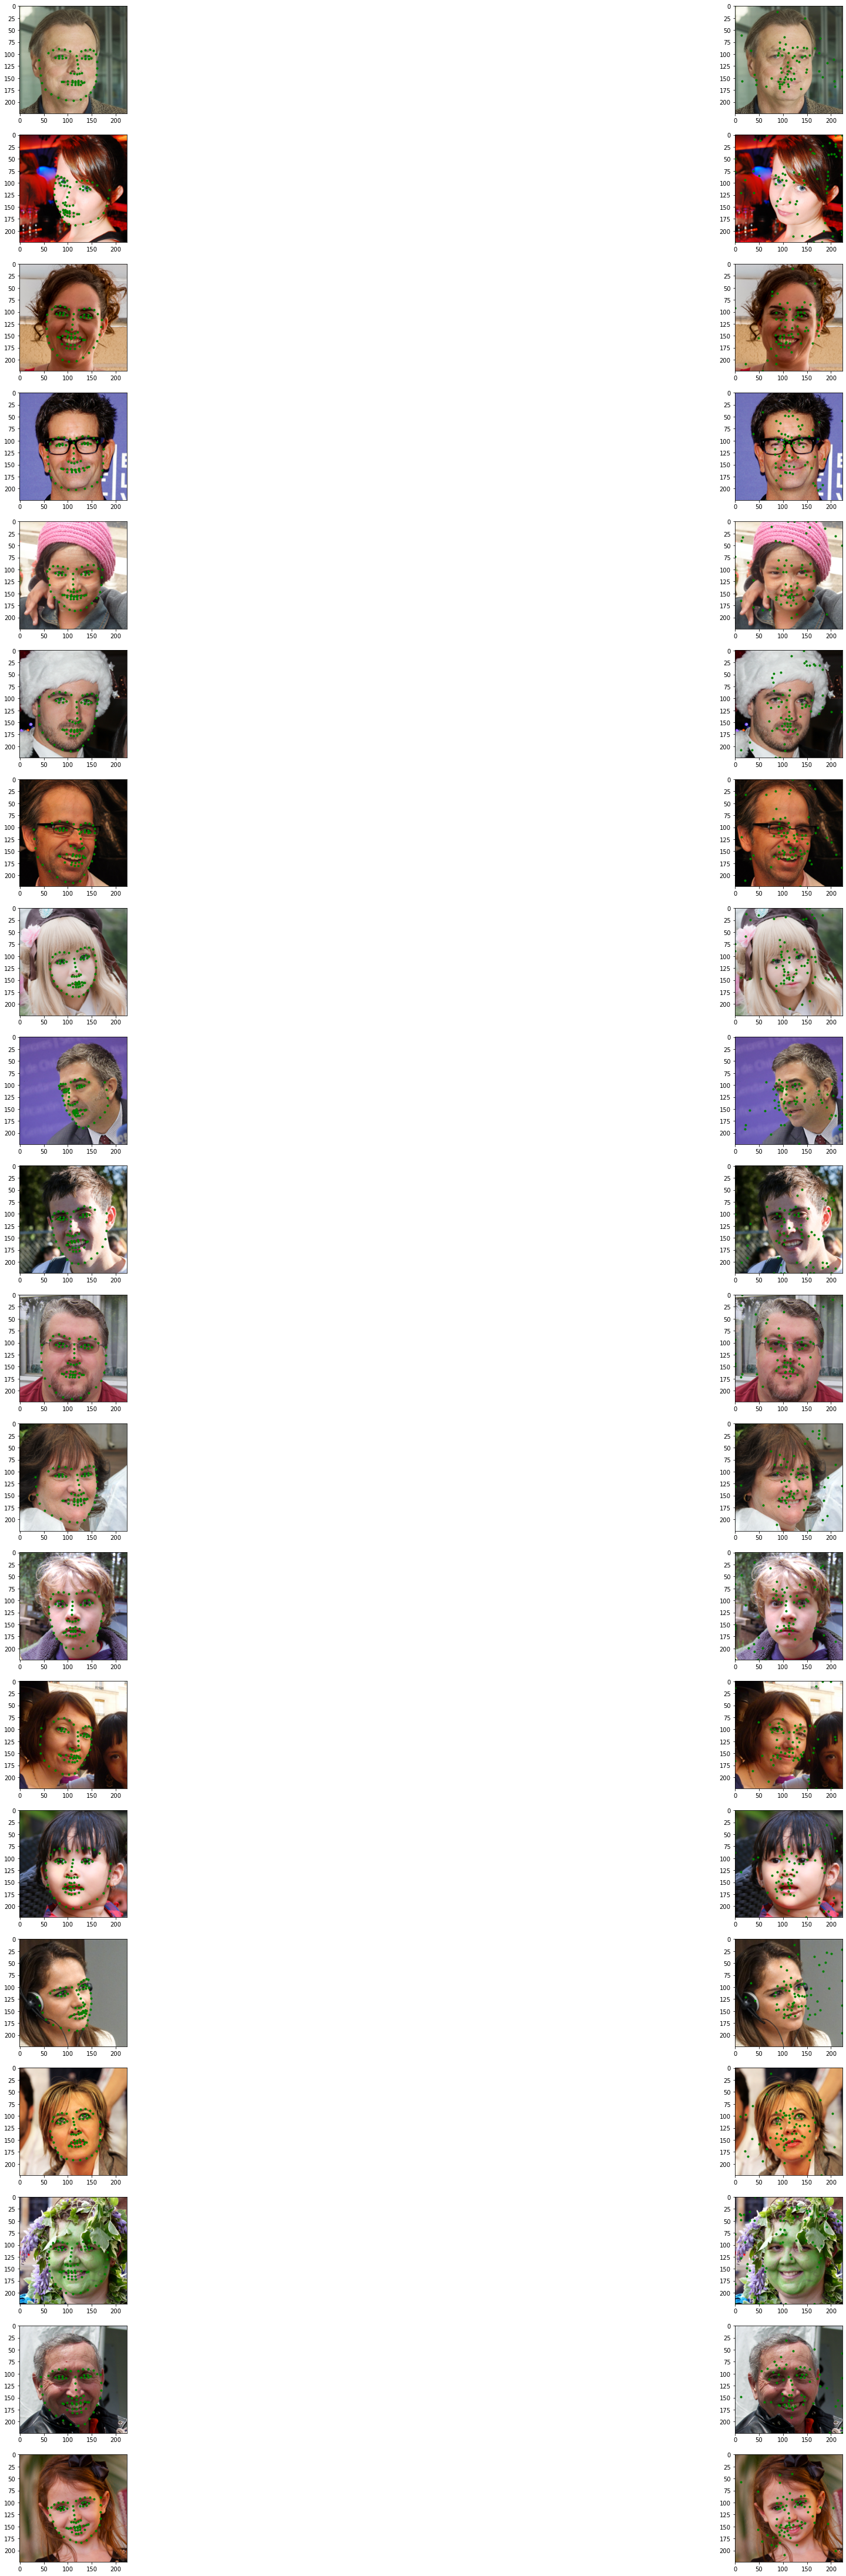

In [40]:
plot_img_classification(predictions)

In [41]:
tens = torch.randn(1, 68, 4, 4)

In [42]:
softmaxed = soft(tens)

In [43]:
for i in range(68):
    print(f"Non softmaxed tensors: {tens[0][i].argmax()}")
    print(f"Softmaxed tensors: {softmaxed[0][i].argmax()}")

Non softmaxed tensors: 7
Softmaxed tensors: 7
Non softmaxed tensors: 5
Softmaxed tensors: 5
Non softmaxed tensors: 15
Softmaxed tensors: 15
Non softmaxed tensors: 5
Softmaxed tensors: 5
Non softmaxed tensors: 9
Softmaxed tensors: 9
Non softmaxed tensors: 9
Softmaxed tensors: 9
Non softmaxed tensors: 8
Softmaxed tensors: 8
Non softmaxed tensors: 7
Softmaxed tensors: 7
Non softmaxed tensors: 5
Softmaxed tensors: 5
Non softmaxed tensors: 12
Softmaxed tensors: 12
Non softmaxed tensors: 1
Softmaxed tensors: 1
Non softmaxed tensors: 3
Softmaxed tensors: 3
Non softmaxed tensors: 15
Softmaxed tensors: 15
Non softmaxed tensors: 14
Softmaxed tensors: 14
Non softmaxed tensors: 8
Softmaxed tensors: 8
Non softmaxed tensors: 4
Softmaxed tensors: 4
Non softmaxed tensors: 10
Softmaxed tensors: 10
Non softmaxed tensors: 4
Softmaxed tensors: 4
Non softmaxed tensors: 13
Softmaxed tensors: 13
Non softmaxed tensors: 0
Softmaxed tensors: 0
Non softmaxed tensors: 1
Softmaxed tensors: 1
Non softmaxed tensors:

In [44]:
tens[0][0]

tensor([[-0.5660,  0.5928,  0.4930,  0.2314],
        [ 0.2794, -0.4160,  1.2772,  2.5945],
        [ 1.7409,  0.4793, -1.0041, -0.8595],
        [-1.1929, -0.4169,  1.0769, -1.0728]])

In [45]:
softmaxed[0][0]

tensor([[0.0046, 0.0151, 0.0191, 0.0110],
        [0.0134, 0.0062, 0.0356, 0.0967],
        [0.0591, 0.0157, 0.0038, 0.0040],
        [0.0027, 0.0059, 0.0303, 0.0037]])